# Decision Tree Predictor

- Decision Tree
- Categorical variables are transformed into a "vote", which is either -1 or 1 depending on the variable value

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import pandas
import numpy
import itertools
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree
from sklearn.metrics import log_loss
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import CategoricalNB

In [3]:
import loan_approval_lib
from loan_approval_lib import logspace, linspace

In [4]:
data = loan_approval_lib.load_original_data()

In [5]:
data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3,1
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2,0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3,1
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,N,2,1
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0.11,N,30,0
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0.15,N,19,0
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,0.46,N,28,1
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0.10,N,26,0


# Data Cleaning

In [6]:
columns = [
    'person_age',
    'person_income',
    'person_emp_length',
    'loan_amnt',
    'loan_int_rate',
    'loan_percent_income',
    'cb_person_default_on_file'
]

for column in columns:
    row_count_1 = len(data)

    if column == 'person_age':
        data = data[data['person_age'] <= 100]

    if column == 'person_emp_length':
        data = data[data['person_emp_length'] <= 100]

    data = data[data[column].isna() == False]
    
    row_count_2 = len(data)
    row_count_diff = row_count_1 - row_count_2
    print(f'column {column}, number of removed rows: {row_count_diff}')


column person_age, number of removed rows: 5
column person_income, number of removed rows: 0
column person_emp_length, number of removed rows: 897
column loan_amnt, number of removed rows: 0
column loan_int_rate, number of removed rows: 3047
column loan_percent_income, number of removed rows: 0
column cb_person_default_on_file, number of removed rows: 0


# Loan Grade

In [7]:
loan_grades = list(sorted(data['loan_grade'].unique()))

data['loan_grade_vote'] = 0

for loan_grade in loan_grades:
    data.loc[data['loan_grade'] == loan_grade, 'loan_grade_vote'] = -1 if loan_grade <= 'C' else 1

data['loan_grade_predict'] = data['loan_grade_vote'].map(lambda x: 0 if x == -1 else 1)

In [8]:
(data['loan_status'] == data['loan_grade_predict']).sum() / len(data)

np.float64(0.8180008382229673)

# Person Home Ownership

In [10]:
data.loc[data['person_home_ownership'] == 'OWN', 'person_home_ownership_vote'] = -1
data.loc[data['person_home_ownership'] == 'MORTGAGE', 'person_home_ownership_vote'] = -1
data.loc[data['person_home_ownership'] == 'RENT', 'person_home_ownership_vote'] = 1
data.loc[data['person_home_ownership'] == 'OTHER', 'person_home_ownership_vote'] = 1

data['person_home_ownership_predict'] = data['person_home_ownership_vote'].map(lambda x: 0 if x == -1 else 1)

In [11]:
(data['loan_status'] == data['person_home_ownership_predict']).sum() / len(data)

np.float64(0.5912964515227718)

# Loan Intent

In [13]:
data.loc[data['loan_intent'] == 'DEBTCONSOLIDATION', 'loan_intent_vote'] = 1
data.loc[data['loan_intent'] == 'EDUCATION', 'loan_intent_vote'] = -1
data.loc[data['loan_intent'] == 'HOMEIMPROVEMENT', 'loan_intent_vote'] = 1
data.loc[data['loan_intent'] == 'MEDICAL', 'loan_intent_vote'] = 1
data.loc[data['loan_intent'] == 'PERSONAL', 'loan_intent_vote'] = -1
data.loc[data['loan_intent'] == 'VENTURE', 'loan_intent_vote'] = -1

data['loan_intent_predict'] = data['loan_intent_vote'].map(lambda x: 0 if x == -1 else 1)

In [14]:
(data['loan_status'] == data['loan_intent_predict']).sum() / len(data)

np.float64(0.5745319921765857)

# Default on File

In [15]:
data.loc[data['cb_person_default_on_file'] == 'Y', 'cb_person_default_on_file_vote'] = 1
data.loc[data['cb_person_default_on_file'] == 'N', 'cb_person_default_on_file_vote'] = -1

data['cb_person_default_on_file_predict'] = data['cb_person_default_on_file_vote'].map(lambda x: 0 if x == -1 else 1)

In [16]:
(data['loan_status'] == data['cb_person_default_on_file_predict']).sum() / len(data)

np.float64(0.739731768650461)

# Choose Columns for Tree Model

In [18]:
for column in data.columns:
    print(column)

person_age
person_income
person_home_ownership
person_emp_length
loan_intent
loan_grade
loan_amnt
loan_int_rate
loan_percent_income
cb_person_default_on_file
cb_person_cred_hist_length
loan_status
loan_grade_vote
loan_grade_predict
person_home_ownership_vote
person_home_ownership_predict
loan_intent_vote
loan_intent_predict
cb_person_default_on_file_vote
cb_person_default_on_file_predict


In [23]:
decision_tree_columns = [
    column for column in data.columns if column.endswith('_vote') and column != 'loan_status_vote'
]

list(
    map(
        decision_tree_columns.append,
        [
            'person_age',
            'person_income',
            'person_emp_length',
            'loan_amnt',
            'loan_int_rate',
            'loan_percent_income',
            'cb_person_cred_hist_length',
        ],
    )
)

for column in decision_tree_columns:
    print(column)

loan_grade_vote
person_home_ownership_vote
loan_intent_vote
cb_person_default_on_file_vote
person_age
person_income
person_emp_length
loan_amnt
loan_int_rate
loan_percent_income
cb_person_cred_hist_length


In [25]:
X = data[decision_tree_columns].copy()
Y = data['loan_status'].copy()

# Run Decision Tree Model - No Max Depth

In [26]:
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X, Y)

In [27]:
Z = clf.predict(X)

In [28]:
data['loan_status_tree_predict'] = Z

In [29]:
(data['loan_status'] == data['loan_status_tree_predict']).sum() / len(data)

np.float64(0.9999301480860575)

In [30]:
feature_importances = pandas.Series(clf.feature_importances_, index=X.columns)
print(feature_importances.sort_values(ascending=False))

loan_percent_income               0.209283
person_income                     0.165178
loan_grade_vote                   0.150188
person_home_ownership_vote        0.125556
loan_int_rate                     0.093362
person_emp_length                 0.069803
person_age                        0.058625
loan_amnt                         0.054860
cb_person_cred_hist_length        0.036704
loan_intent_vote                  0.030520
cb_person_default_on_file_vote    0.005921
dtype: float64


In [45]:
for index, column in enumerate(decision_tree_columns):
    print(f'index={index} column={column}')

index=0 column=loan_grade_vote
index=1 column=person_home_ownership_vote
index=2 column=loan_intent_vote
index=3 column=cb_person_default_on_file_vote
index=4 column=person_age
index=5 column=person_income
index=6 column=person_emp_length
index=7 column=loan_amnt
index=8 column=loan_int_rate
index=9 column=loan_percent_income
index=10 column=cb_person_cred_hist_length


# Decision Tree Model - Max Depth 1

In [32]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=1)
clf = clf.fit(X, Y)

In [33]:
Z = clf.predict(X)

In [34]:
data['loan_status_tree_predict'] = Z

In [35]:
(data['loan_status'] == data['loan_status_tree_predict']).sum() / len(data)

np.float64(0.8317267393126572)

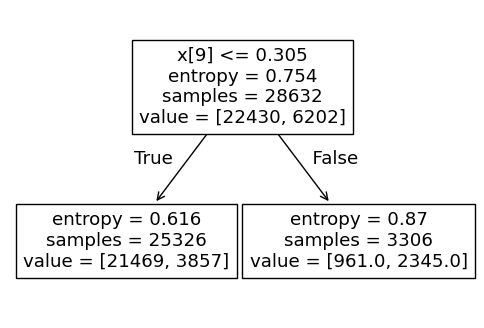

In [36]:
width = 6
height = 4
plt.figure(figsize=(width, height))

#tree_plot_max_depth = 6
tree.plot_tree(clf) #, max_depth=tree_plot_max_depth)

plt.savefig('tree-max-depth-numerical-1.pdf')
plt.savefig('tree-max-depth-numerical-1.png')
plt.show()

In [37]:
feature_importances = pandas.Series(clf.feature_importances_, index=X.columns)
print(feature_importances.sort_values(ascending=False))

loan_percent_income               1.0
person_home_ownership_vote        0.0
loan_grade_vote                   0.0
loan_intent_vote                  0.0
cb_person_default_on_file_vote    0.0
person_income                     0.0
person_age                        0.0
person_emp_length                 0.0
loan_amnt                         0.0
loan_int_rate                     0.0
cb_person_cred_hist_length        0.0
dtype: float64


# Decision Tree Model - Max Depth 2

In [38]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=2)
clf = clf.fit(X, Y)

In [39]:
Z = clf.predict(X)

In [40]:
data['loan_status_tree_predict'] = Z

In [41]:
(data['loan_status'] == data['loan_status_tree_predict']).sum() / len(data)

np.float64(0.8731139983235541)

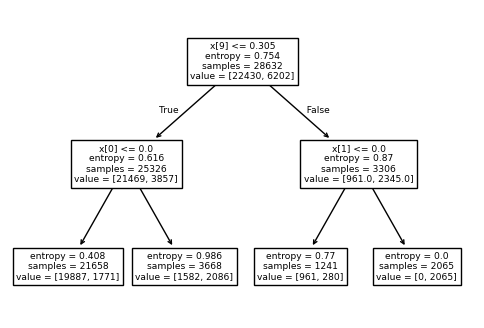

In [42]:
width = 6
height = 4
plt.figure(figsize=(width, height))

#tree_plot_max_depth = 6
tree.plot_tree(clf) #, max_depth=tree_plot_max_depth)

plt.savefig('tree-max-depth-numerical-2.pdf')
plt.savefig('tree-max-depth-numerical-2.png')
plt.show()

In [43]:
feature_importances = pandas.Series(clf.feature_importances_, index=X.columns)
print(feature_importances.sort_values(ascending=False))

loan_grade_vote                   0.382805
loan_percent_income               0.382253
person_home_ownership_vote        0.234942
loan_intent_vote                  0.000000
cb_person_default_on_file_vote    0.000000
person_income                     0.000000
person_age                        0.000000
person_emp_length                 0.000000
loan_amnt                         0.000000
loan_int_rate                     0.000000
cb_person_cred_hist_length        0.000000
dtype: float64


In [44]:
for index, column in enumerate(decision_tree_columns):
    print(f'index={index} column={column}')

index=0 column=loan_grade_vote
index=1 column=person_home_ownership_vote
index=2 column=loan_intent_vote
index=3 column=cb_person_default_on_file_vote
index=4 column=person_age
index=5 column=person_income
index=6 column=person_emp_length
index=7 column=loan_amnt
index=8 column=loan_int_rate
index=9 column=loan_percent_income
index=10 column=cb_person_cred_hist_length
